In [1]:
import pandas as pd
from plot_params import *
stat_all = pd.read_csv(outdir / 'neural_network_enrichment_human_30bp.csv', index_col = 0)

In [2]:
# homer scoring of known motif
stat_homer = pd.read_csv(outdir / 'motif_enrichment_human_all_30bp.csv', index_col = 0)

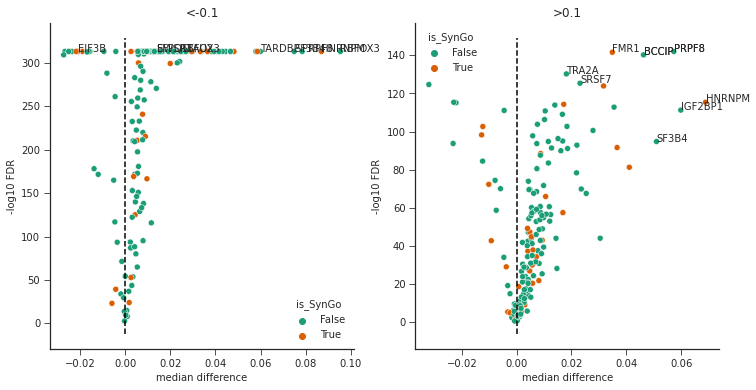

In [3]:
f, axes = plt.subplots(1,2, figsize = (12,6))
for ax, (name, group) in zip(axes.flatten(),stat_all.groupby(by = ['category'])):
    sns.scatterplot(data = group, x = 'median difference', y = '-log10 FDR', ax = ax, hue = 'is_SynGo')
    ax.set_title(name)
    sig1 = group.loc[(group['sig'])].sort_values(by = 'median difference', ascending = False).iloc[:5]
    sig2 = group.loc[(group['sig'])].sort_values(by = '-log10 FDR', ascending = False).iloc[:5]
    sig = pd.concat([sig1, sig2], axis = 0)
    for index, row in sig.iterrows():
        ax.text(row['median difference'], row['-log10 FDR'], row['RBPNet_model'].split('_')[0])
    ax.vlines(x = 0, ymin = ax.get_ylim()[0],ymax = ax.get_ylim()[1], linestyle = 'dashed', color = 'black')
sns.despine()
plt.savefig(figdir / 'human_30bp_volcano.pdf')

In [4]:
figdir

PosixPath('/tscc/nfs/home/hsher/scratch/karen_fig')

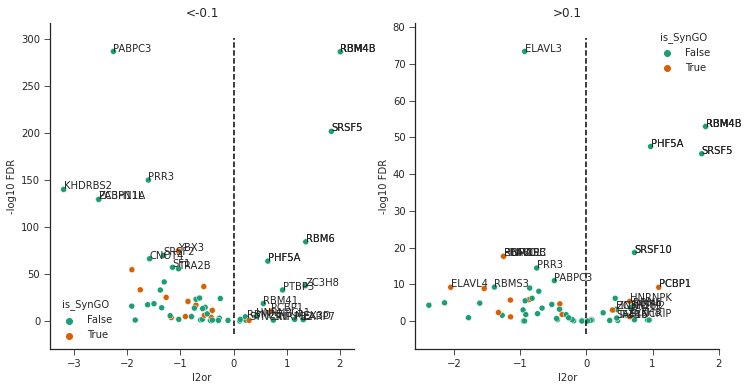

In [5]:
f, axes = plt.subplots(1,2, figsize = (12,6))
for ax, (name, group) in zip(axes.flatten(),stat_homer.groupby(by = ['category'])):
    sns.scatterplot(data = group, x = 'l2or', y = '-log10 FDR', ax = ax, hue = 'is_SynGO')
    ax.set_title(name)
    sig1 = group.loc[(group['sig'])].sort_values(by = 'odds ratio', ascending = False).iloc[:15]
    sig2 = group.loc[(group['sig'])].sort_values(by = '-log10 FDR', ascending = False).iloc[:15]
    sig = pd.concat([sig1, sig2], axis = 0)
    for index, row in sig.iterrows():
        ax.text(row['l2or'], row['-log10 FDR'], row['experiment'].split('_')[0])
    ax.vlines(x = 0, ymin = ax.get_ylim()[0],ymax = ax.get_ylim()[1], linestyle = 'dashed', color = 'black')
sns.despine()
plt.savefig(figdir / 'human_30bp_volcano_HOMER.pdf')

# Exploratory analysis for RBPNet score analysis

In [6]:
# make string network
','.join(stat_all.loc[(stat_all['FDR']<0.05)&(stat_all['category']=='<-0.1')&
         (stat_all['median difference']>0.02),
'RBP_official'].tolist())

# the median difference threshold is arbitrary
# go to STRING, https://string-db.org/cgi/input?sessionId=b97EwZq9WRAL&input_page_show_search=on
# select mutliple proteins
# paste this into the list of names
# organism select human

'SUGP2,CELF1,DICER1,HNRNPM,RBM15,ELAC2,DEK,EIF3A,TIA1,IGF2BP1,SRSF7,BCCIP,IGF2BP3,SF3B4,RBFOX2,U2AF2,PRPF8,EXOSC5,EIF4G2,PRPF39,TARDBP,NONO,RBFOX3,MATR3,PCBP2,STAU2,EIF2B5,SUZ12,EED,EIF4H,PRPF8,MATR3,SND1,EIF4G2,FMR1,HNRNPK,PTBP1,TIA1,RBFOX3,TARDBP,CDC40,CSTF2T,IGF2BP1,NONO,U2AF2,GTF2F1,HNRNPM,PTBP1'

In [7]:
# make string network
','.join(stat_all.loc[(stat_all['FDR']<0.05)&(stat_all['category']=='>0.1')&
         (stat_all['median difference']>0.02),
'RBP_official'].tolist())

# the median difference threshold is arbitrary
# go to STRING, https://string-db.org/cgi/input?sessionId=b97EwZq9WRAL&input_page_show_search=on
# select mutliple proteins
# paste this into the list of names
# organism select human

'HNRNPM,IGF2BP1,SRSF7,BCCIP,IGF2BP3,SF3B4,RBFOX2,PRPF8,RBFOX3,EIF4G2,FMR1,HNRNPK,TIA1,TARDBP,CSTF2T,U2AF2,HNRNPM'

In [8]:
stat_all.loc[(stat_all['sig'])&(stat_all['category']=='<-0.1')&(stat_all['median difference']>0),
'RBP_official'].shape

(145,)

Text(0.5, 0, '<-0.1 median difference')

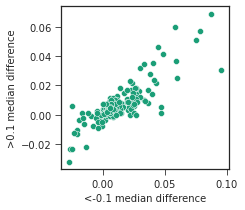

In [9]:
# correlating the score for supressing and enhancing motifs
f, ax = plt.subplots(figsize = (3,3))
median_difference_pv = pd.pivot_table(stat_all, index = 'RBPNet_model', columns = 'category',
               values = 'median difference')
sns.scatterplot(data =median_difference_pv,
                x = '<-0.1',
                y = '>0.1',
               ax = ax)
plt.ylabel('>0.1 median difference')
plt.xlabel('<-0.1 median difference')

In [10]:
# correlating changes with model performance
tabledir = Path('/tscc/nfs/home/hsher/ps-yeolab5/ENCODE_paper_tables/')
metrics=pd.read_csv(tabledir/'model_performance.csv', index_col = 0)

Text(0.5, 1.0, 'Pearson r=0.22')

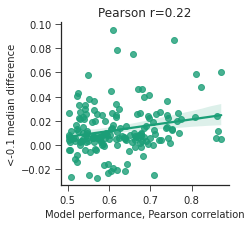

In [11]:
merged_pv = median_difference_pv.merge(metrics, left_index = True, right_on = 'Experiment')
f, ax = plt.subplots(figsize = (3,3))
sns.regplot(data = merged_pv, y = '<-0.1', x = 'dlogodds pearson(total>50)')
sns.despine()
from scipy.stats import pearsonr
r, p = pearsonr(merged_pv['<-0.1'], merged_pv['dlogodds pearson(total>50)'])
plt.ylabel('<-0.1 median difference')
plt.xlabel('Model performance, Pearson correlation')
plt.title(f'Pearson r={r:.2f}')

Text(0.5, 1.0, 'Pearson r=0.44')

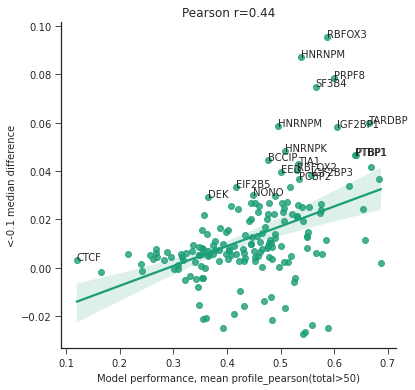

In [12]:
#merged_pv = median_difference_pv.merge(metrics, left_index = True, right_on = 'Experiment')
from scipy.stats import pearsonr
import numpy as np
from sklearn.linear_model import LinearRegression
f, ax = plt.subplots(figsize = (6,6))
xcol = 'mean profile_pearson(total>50)'
ycol = '<-0.1'
sns.regplot(data = merged_pv, y = ycol, x = xcol)
sns.despine()

r, p = pearsonr(merged_pv[ycol], merged_pv[xcol])



X = merged_pv[[xcol]]

# y = 1 * x_0 + 2 * x_1 + 3

y = merged_pv[ycol]
reg = LinearRegression().fit(X, y)
merged_pv[f'predicted_median_{ycol}']=reg.predict(X)
merged_pv[f'residual_{ycol}']=y-merged_pv[f'predicted_median_{ycol}']

for index, row in merged_pv.sort_values(by = f'residual_{ycol}', ascending = False).iloc[:20].iterrows():
    ax.text(row[xcol], row[ycol], row['Experiment'].split('_')[0])
plt.ylabel(f'{ycol} median difference')
plt.xlabel(f'Model performance, {xcol}')
plt.title(f'Pearson r={r:.2f}')

Text(0.5, 1.0, 'Pearson r=0.22')

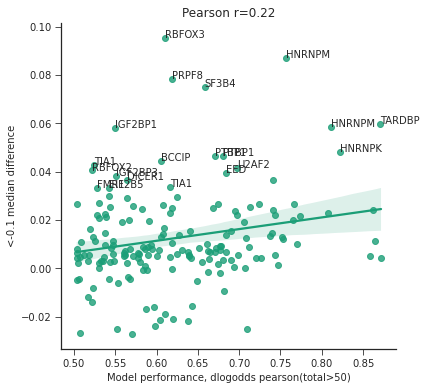

In [13]:
#merged_pv = median_difference_pv.merge(metrics, left_index = True, right_on = 'Experiment')
from scipy.stats import pearsonr
import numpy as np
from sklearn.linear_model import LinearRegression
f, ax = plt.subplots(figsize = (6,6))
xcol = 'dlogodds pearson(total>50)'
ycol = '<-0.1'
sns.regplot(data = merged_pv, y = ycol, x = xcol)
sns.despine()

r, p = pearsonr(merged_pv[ycol], merged_pv[xcol])



X = merged_pv[[xcol]]

# y = 1 * x_0 + 2 * x_1 + 3

y = merged_pv[ycol]
reg = LinearRegression().fit(X, y)
merged_pv[f'predicted_median_{ycol}']=reg.predict(X)
merged_pv[f'residual_{ycol}']=y-merged_pv[f'predicted_median_{ycol}']

for index, row in merged_pv.sort_values(by = f'residual_{ycol}', ascending = False).iloc[:20].iterrows():
    ax.text(row[xcol], row[ycol], row['Experiment'].split('_')[0])
plt.ylabel(f'{ycol} median difference')
plt.xlabel(f'Model performance, {xcol}')
plt.title(f'Pearson r={r:.2f}')

# exploratory analysis for homer results

Text(0.5, 0, '<-0.1 odds ratio')

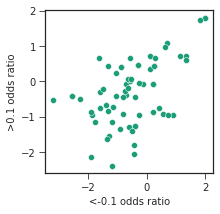

In [14]:
pv = pd.pivot_table(stat_homer, index = 'experiment', columns = 'category',
               values = 'l2or')

f, ax = plt.subplots(figsize = (3,3))

sns.scatterplot(data =pv,
                x = '<-0.1',
                y = '>0.1',ax = ax)
plt.ylabel('>0.1 odds ratio')
plt.xlabel('<-0.1 odds ratio')

In [15]:
','.join(stat_homer.loc[(stat_homer['FDR']<0.05)&(stat_homer['category']=='<-0.1')&
         (stat_homer['odds ratio']>1),
'RBP'].tolist())


'MEX3D,ZC3H8,LARP7,HNRNPCL1,SRSF5,RBM25,SRSF10,PTBP3,HNRNPH2,ZC3H18,RBM4B,RBM4,RBM6,CELF1,PHF5A,RBM41,PCBP1'

In [16]:
','.join(stat_homer.loc[(stat_homer['FDR']<0.05)&(stat_homer['category']=='>0.1')&
         (stat_homer['odds ratio']>1),
'RBP'].tolist())


'ZC3H8,SRSF5,RBM25,SRSF10,TRA2B,HNRNPH2,ZC3H18,SRSF2,RBM4B,HNRNPK,EXOSC2,RBM4,RBM6,SRSF4,PHF5A,PCBP2,PCBP1'